# Data Augmentation

One of the challenges of applying deep learning in the medical field is the scarcity of labelled datasets. Data augmentation is a technique that helps coping with this problem. By applying a series of image transformation, such as rotation, translation, contrast changes, we are able to create "new" training samples, which results in more robust methods and potentially more accuracte results.

The goal of this tutorial is:
 - Illustrate data augmentation using the Keras API. 

In [1]:
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pylab as plt
# load data
import numpy as np
from scipy.misc import imread, imsave
from skimage.morphology import binary_erosion, binary_dilation

import sys
MY_UTILS_PATH = '../Modules/'
if not MY_UTILS_PATH in sys.path:
    sys.path.append(MY_UTILS_PATH)
import ipt_utils

Using TensorFlow backend.


## Loading and displaying a sample image

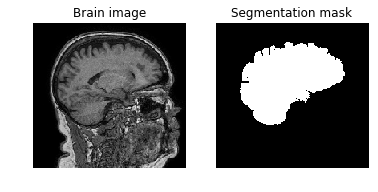

In [2]:
#Loading sample image and its mask
sample_brain = imread("../Data/brain_slice.png") 
sample_mask = imread("../Data/brain_slice_mask.png")

#Displaying image and its mask
plt.subplot(121)
plt.title("Brain image")
plt.imshow(sample_brain,cmap = "gray")
plt.axis("off")
plt.subplot(122)
plt.imshow(sample_mask,cmap = "gray")
plt.axis("off")
plt.title("Segmentation mask")
plt.show()   

## Applying Keras data augmentation

/home/roberto/Documents/virtualenv/venv02/local/lib/python2.7/site-packages/keras/preprocessing/image.py:653: UserWarning: Expected input to be images (as Numpy array) following the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1, 182, 191, 1) (1 channels).
  ' (' + str(x.shape[self.channel_axis]) + ' channels).')


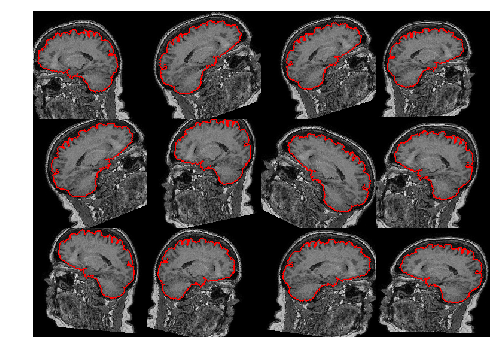

In [3]:
seed = 15 #random number generator seed

# Putting arrays in (nsamples,H,W,nchannels) convention
patches = sample_brain[np.newaxis,:,:,np.newaxis]
labels = sample_mask[np.newaxis,:,:,np.newaxis]
#Creating image data generator objects
image_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval = 0)

mask_datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.1,
        height_shift_range=0.1,
        shear_range=0.2,
        zoom_range=0.1,
        horizontal_flip=True,
        fill_mode='constant',
        cval = 0)


# Fitting them. Notice that the seed parameter synchronize them
image_datagen.fit(patches, augment=True, seed=seed)
mask_datagen.fit(labels, augment=True, seed=seed)

image_generator = image_datagen.flow(patches,batch_size = 1,seed = seed)
mask_generator = mask_datagen.flow(labels,batch_size = 1,seed = seed)


# function to merge generators
def combine_generator(gen1, gen2):
    while True:
        yield(gen1.next(), gen2.next())

# combine generators into one which yields image and masks
combined = combine_generator(image_generator, mask_generator)

i = 0
imgs = np.zeros((12,patches.shape[1],patches.shape[2]),dtype = np.uint8)
masks = np.zeros((12,patches.shape[1],patches.shape[2]),dtype = bool)
nsamples = 12

for ii in combined:
    img = ii[0][0,:,:,0]
    #img = 1.0*(img-img.min())/(img.max()-img.min())
    #img = (img*255).astype(np.uint8)
    mask = ii[1][0,:,:,0] > 0
    mask = np.logical_xor(binary_dilation(mask),binary_erosion(mask))
    imgs[i] = img
    masks[i] = mask    
    i+=1
    if i >= nsamples:
        break

#Displaying data augmented dataset
img_overlaid = ipt_utils.gshow(ipt_utils.mosaic(imgs,4),\
                               ipt_utils.mosaic(masks,4))
plt.figure(figsize=(12,6))
plt.imshow(img_overlaid,cmap = "gray")
plt.axis("off")
plt.show()  